# Preprocess cholera outbreaks

This notebook cleans and transforms the previously extracted and cleaned cholera outbreaks data from the [Integrated Disease Surveillance Programme of India](https://idsp.nic.in/) (IDSP) and saves the preprocessed cholera outbreaks in shapefile format.

Prior to running this notebook, execute
- `1_download_the_data/download_outbreaks.py` to download the outbreaks PDF files
- and `2_preprocess_the_data/extract_and_clean_cholera_outbreaks.py` to extract and clean cholera outbreaks from the downloaded outbreaks PDF files.

Properly extracting data from PDF files is tricky. In the present case it works for 91%. The remaining 9% need to be cleaned manually. Districts and start dates also need some more cleaning.

## Setup

In [1]:
# import packages
import numpy as np
import pandas as pd
import re
import geopandas as gpd
import requests
import zipfile
import io

In [2]:
pd.set_option('display.max_rows', None)

## Load and inspect cholera outbreaks

In [3]:
cholera_outbreaks = pd.read_csv('../../data/outbreaks/cholera_outbreaks.csv')
cholera_outbreaks.shape

(597, 6)

In [4]:
cholera_outbreaks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   597 non-null    object
 1   district    597 non-null    object
 2   disease     597 non-null    object
 3   cases       596 non-null    object
 4   deaths      595 non-null    object
 5   start_date  577 non-null    object
dtypes: object(6)
memory usage: 28.1+ KB


In [5]:
cholera_outbreaks.head()

,file_name,district,disease,cases,deaths,start_date
0,31st_2010.pdf,shimla,cholera,235,1*,13.07.10
1,31st_2010.pdf,"alwar, sikar, jaipur",cholera,1095,0 #,20.07.10
2,39th_2010.pdf,dibrugarh,cholera,10,0,10.09.10
3,39th_2010.pdf,belgaum,cholera,19,0,06.09.10
4,41st_2010.pdf,bharuch,cholera,2,0,24.09.10


In [6]:
cholera_outbreaks.isna().sum()

file_name      0
district       0
disease        0
cases          1
deaths         2
start_date    20
dtype: int64

In [7]:
cholera_outbreaks[cholera_outbreaks.duplicated()].shape

(0, 6)

## Check which columns need further cleaning

In [8]:
# check cholera occurrences per column
for column in cholera_outbreaks.columns:
    cholera_occurrences = cholera_outbreaks[cholera_outbreaks[column].fillna('').str.contains('cholera')].shape[0]
    print(f'Number of cholera occurrences in column {column}: {cholera_occurrences}')

Number of cholera occurrences in column file_name: 0
Number of cholera occurrences in column district: 16
Number of cholera occurrences in column disease: 577
Number of cholera occurrences in column cases: 4
Number of cholera occurrences in column deaths: 0
Number of cholera occurrences in column start_date: 1


In [9]:
cholera_outbreaks_column_district = cholera_outbreaks[cholera_outbreaks['district'].str.contains('cholera')]
cholera_outbreaks_column_district.shape

(16, 6)

In [10]:
cholera_outbreaks_column_cases = cholera_outbreaks[cholera_outbreaks['cases'].fillna('').str.contains('cholera')]
cholera_outbreaks_column_cases.shape

(4, 6)

In [11]:
cholera_outbreaks_column_start_date = cholera_outbreaks[cholera_outbreaks['start_date'].fillna('').str.contains('cholera')]
cholera_outbreaks_column_start_date.shape

(1, 6)

In [12]:
cholera_outbreaks_missing_district = cholera_outbreaks[cholera_outbreaks['district'] == 'district missing']
cholera_outbreaks_missing_district.shape

(17, 6)

Cholera outbreaks with missing district and start dates need to be cleaned manually.

In [13]:
cholera_outbreaks = cholera_outbreaks[~(cholera_outbreaks['district'].str.contains('cholera'))
                                      & ~(cholera_outbreaks['cases'].fillna('').str.contains('cholera'))
                                      & ~(cholera_outbreaks['start_date'].fillna('').str.contains('cholera'))
                                      & (cholera_outbreaks['district'] != 'district missing')].reset_index(drop=True)
cholera_outbreaks.shape

(559, 6)

## Clean start dates

In [14]:
# copy start date column
cholera_outbreaks['start_date_clean'] = cholera_outbreaks['start_date']

In [15]:
# fill na
cholera_outbreaks['start_date_clean'] = cholera_outbreaks['start_date_clean'].fillna('')

In [16]:
# remove letters
cholera_outbreaks['start_date_clean'] = cholera_outbreaks['start_date_clean'].apply(lambda x: re.sub(r'[^0-9\s./-]+', '', x))

In [17]:
# replace 0
cholera_outbreaks['start_date_clean'] = cholera_outbreaks['start_date_clean'].apply(lambda x: '' if x == '0' else x)

In [18]:
# separate two dates in a cell
cholera_outbreaks['start_date_clean'] = cholera_outbreaks['start_date_clean'].apply(lambda x: x.split(' ')[0] if len(x.split(' ')) == 2 else x)

In [19]:
# remove whitespace
cholera_outbreaks['start_date_clean'] = cholera_outbreaks['start_date_clean'].str.strip()

In [20]:
cholera_outbreaks_missing_dates = cholera_outbreaks[cholera_outbreaks['start_date_clean'] == '']
cholera_outbreaks_missing_dates.shape

(15, 7)

Cholera outbreaks with missing start dates need to be cleaned manually before they can be further processed.

In [21]:
# load and transform manually cleaned cholera outbreaks
cholera_outbreaks_manually_cleaned = pd.read_csv('../../data/outbreaks/cholera_outbreaks_cleaned_manually.csv')
cholera_outbreaks_manually_cleaned['district'] = cholera_outbreaks_manually_cleaned['district'].str.lower()
cholera_outbreaks_manually_cleaned = cholera_outbreaks_manually_cleaned.rename(columns={'start_date': 'start_date_clean'})
cholera_outbreaks_manually_cleaned = cholera_outbreaks_manually_cleaned.drop_duplicates()
cholera_outbreaks_manually_cleaned.shape

(53, 6)

In [22]:
# get cholera outbreaks without missing start dates
cholera_outbreaks = cholera_outbreaks[cholera_outbreaks['start_date_clean'] != ''].reset_index(drop=True)
cholera_outbreaks.shape

(544, 7)

In [23]:
# merge cholera outbreaks again
cholera_outbreaks = pd.concat([cholera_outbreaks, cholera_outbreaks_manually_cleaned], ignore_index=True)
cholera_outbreaks.shape

(597, 7)

In [24]:
# harmonise date formats to extract year
cholera_outbreaks['year'] = cholera_outbreaks['start_date_clean'].apply(lambda x: x.split('.')[2] if '.' in x
                                                                        else (x.split('/')[2] if '/' in x
                                                                              else (x.split('-')[2] if '-' in x
                                                                                    else x)))

In [25]:
# further harmonise date formats and extract years
cholera_outbreaks['year'] = cholera_outbreaks['year'].str.pad(width=3, side='left', fillchar='0')
cholera_outbreaks['year'] = cholera_outbreaks['year'].str.pad(width=4, side='left', fillchar='2')
cholera_outbreaks['year'] = cholera_outbreaks['year'].astype(np.int64)

In [26]:
# check years
sorted(cholera_outbreaks['year'].unique())

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [27]:
# check case where there seems to be a typo
cholera_outbreaks.loc[cholera_outbreaks['year'] == 2019]

,file_name,district,disease,cases,deaths,start_date,start_date_clean,year
356,39th_2015.pdf,bagalkot,cholera,66,00,20-09-19,20-09-19,2019


In [28]:
# fix typo
cholera_outbreaks.loc[(cholera_outbreaks['file_name'] == '39th_2015.pdf') & (cholera_outbreaks['year'] == 2019), 'year'] = 2015

In [29]:
# harmonise date formats to extract month
cholera_outbreaks['month'] = cholera_outbreaks['start_date_clean'].apply(lambda x: x.split('.')[1] if '.' in x
                                                                         else (x.split('/')[1] if '/' in x
                                                                               else (x.split('-')[1] if '-' in x
                                                                                     else x)))

In [30]:
# cast month to integer
cholera_outbreaks['month'] = cholera_outbreaks['month'].astype(np.int64)

In [31]:
# check months
sorted(cholera_outbreaks['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [32]:
cholera_outbreaks.shape

(597, 9)

In [33]:
# drop rows, drop columns, add cholera outbreak column
cholera_outbreaks = cholera_outbreaks.loc[cholera_outbreaks['year'].isin(np.arange(2010, 2019))].reset_index(drop=True)
cholera_outbreaks = cholera_outbreaks.drop(['disease', 'cases', 'deaths', 'start_date'], axis=1)
cholera_outbreaks = cholera_outbreaks.rename(columns={'start_date_clean': 'start_date'})
cholera_outbreaks['outbreak'] = 1
cholera_outbreaks.shape

(596, 6)

In [34]:
cholera_outbreaks.head()

,file_name,district,start_date,year,month,outbreak
0,31st_2010.pdf,shimla,13.07.10,2010,7,1
1,31st_2010.pdf,"alwar, sikar, jaipur",20.07.10,2010,7,1
2,39th_2010.pdf,dibrugarh,10.09.10,2010,9,1
3,39th_2010.pdf,belgaum,06.09.10,2010,9,1
4,41st_2010.pdf,bharuch,24.09.10,2010,9,1


## Map states, districts and location

Next, we need to map states and districts to their geographic location. We do this with the help of the [Database of Global Administrative Areas](https://www.gadm.org/index.html). We download the Level 2 administrative zones for India and explore them before we extract the relevant information and merge it with the outbreaks data.

In [35]:
!wget --recursive --no-directories --no-clobber --directory-prefix=../../data/outbreaks https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_IND_shp.zip

File ‘../../data/outbreaks/gadm36_IND_shp.zip’ already there; not retrieving.



In [36]:
!unzip -u -d ../../data/outbreaks/gadm36_IND_shp ../../data/outbreaks/gadm36_IND_shp.zip

Archive:  ../../data/outbreaks/gadm36_IND_shp.zip


In [37]:
india = gpd.read_file('../../data/outbreaks/gadm36_IND_shp/gadm36_IND_2.shp')
india.shape

(666, 14)

In [38]:
india.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
india.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_0      666 non-null    object  
 1   NAME_0     666 non-null    object  
 2   GID_1      666 non-null    object  
 3   NAME_1     666 non-null    object  
 4   NL_NAME_1  0 non-null      float64 
 5   GID_2      666 non-null    object  
 6   NAME_2     666 non-null    object  
 7   VARNAME_2  190 non-null    object  
 8   NL_NAME_2  0 non-null      float64 
 9   TYPE_2     666 non-null    object  
 10  ENGTYPE_2  666 non-null    object  
 11  CC_2       0 non-null      float64 
 12  HASC_2     626 non-null    object  
 13  geometry   666 non-null    geometry
dtypes: float64(3), geometry(1), object(10)
memory usage: 73.0+ KB


In [40]:
india.head()

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IND,India,IND.1_1,Andaman and Nicobar,NaN,IND.1.1_1,Nicobar Islands,NaN,NaN,District,District,NaN,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,IND,India,IND.1_1,Andaman and Nicobar,NaN,IND.1.2_1,North and Middle Andaman,NaN,NaN,District,District,NaN,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,IND,India,IND.1_1,Andaman and Nicobar,NaN,IND.1.3_1,South Andaman,NaN,NaN,District,District,NaN,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."
3,IND,India,IND.2_1,Andhra Pradesh,NaN,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",NaN,District,District,NaN,IN.AD.AN,"POLYGON ((77.71420 13.76079, 77.71314 13.75074..."
4,IND,India,IND.2_1,Andhra Pradesh,NaN,IND.2.2_1,Chittoor,Chitoor|Chittor,NaN,District,District,NaN,IN.AD.CH,"POLYGON ((78.46293 12.63537, 78.46190 12.63228..."


<AxesSubplot: >

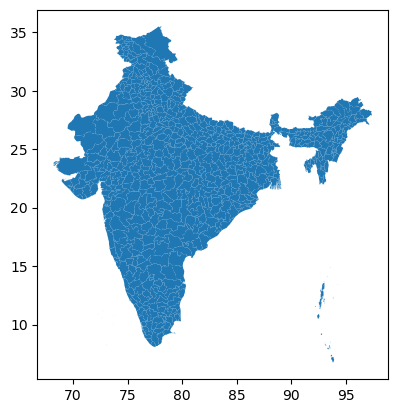

In [41]:
india.plot()

In [42]:
# select states, districts and geometry
states_districts = india[['NAME_1', 'NAME_2', 'geometry']].copy()

In [43]:
# rename columns
states_districts.columns = ['state', 'district', 'geometry']

In [44]:
# make states and districts lowercase to simplify the mapping
states_districts['state'] = states_districts['state'].str.lower()
states_districts['district'] = states_districts['district'].str.lower()

In [45]:
# create list with unique districts
districts = states_districts['district'].unique().tolist()

In [46]:
# harmonise district names in district to simplify mapping
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'mahabubnagar', 'district'] = 'mahbubnagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'ahmedabad', 'district'] = 'ahmadabad'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'howrah', 'district'] = 'haora'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'hooghly', 'district'] = 'hugli'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'hoogly', 'district'] = 'hugli'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'villupuram', 'district'] = 'viluppuram'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'haridwar', 'district'] = 'hardwar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'davangere', 'district'] = 'davanagere'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'davengere', 'district'] = 'davanagere'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'davangare', 'district'] = 'davanagere'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'tiruchirapalli', 'district'] = 'tiruchirappalli'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'darang', 'district'] = 'darrang'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'virudhunager', 'district'] = 'virudunagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'chikkaballapur', 'district'] = 'chikballapura'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'gondia', 'district'] = 'gondiya'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'purulia', 'district'] = 'puruliya'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kalaburagi', 'district'] = 'gulbarga'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kalburgi', 'district'] = 'gulbarga'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'gulburga', 'district'] = 'gulbarga'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'berhampur', 'district'] = 'ganjam'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'sholapur', 'district'] = 'solapur'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'raigad', 'district'] = 'raigarh'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'panchmahal', 'district'] = 'panch mahals'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'sibsagar', 'district'] = 'sivasagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'banaskantha', 'district'] = 'banas kantha'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'chamarajnagar', 'district'] = 'chamrajnagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'khargaon', 'district'] = 'west nimar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'mysuru', 'district'] = 'mysore'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'mohali', 'district'] = 'sahibzada ajit singh nagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'delhi', 'district'] = 'west'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kawardha', 'district'] = 'kabeerdham'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'chirtadurga', 'district'] = 'chitradurga'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'budgam', 'district'] = 'badgam'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'jangir', 'district'] = 'janjgir-champa'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kancheepuramsaidapet', 'district'] = 'kancheepuram'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'thiruvannamalai', 'district'] = 'tiruvannamalai'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'sabarkantha', 'district'] = 'sabar kantha'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'alwar, sikar, jaipur', 'district'] = 'alwar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'badwani', 'district'] = 'barwani'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'balasore', 'district'] = 'baleshwar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'bangalore urban', 'district'] = 'bangalore'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'bardhaman', 'district'] = 'barddhaman'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'belagavi', 'district'] = 'belgaum'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'chota udaipur', 'district'] = 'chhota udaipur'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'd&n haveli', 'district'] = 'dadra and nagar haveli'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'dadra & nagar haveli', 'district'] = 'dadra and nagar haveli'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'east champaran', 'district'] = 'purba champaran'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'gandhi nagar', 'district'] = 'gandhinagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'janjgir', 'district'] = 'janjgir-champa'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kalaburgi (gulbarga)', 'district'] = 'gulbarga'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kamrup ( metro)', 'district'] = 'kamrup metropolitan'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kamrup metro', 'district'] = 'kamrup metropolitan'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'kancheepuram(saidapet)', 'district'] = 'kancheepuram'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'khandwa', 'district'] = 'east nimar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'malda', 'district'] = 'maldah'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'medinipur west', 'district'] = 'pashchim medinipur'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'name of district mathura', 'district'] = 'mathura'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'new delhi', 'district'] = 'west'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'north 24 paraganas', 'district'] = 'north 24 parganas'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'north 24 pargans', 'district'] = 'north 24 parganas'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'north 24 praganas', 'district'] = 'north 24 parganas'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'north delhi', 'district'] = 'west'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'north district', 'district'] = 'west'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'purlia', 'district'] = 'puruliya'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'rampurhat', 'district'] = 'birbhum'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'ratlam sonepur', 'district'] = 'ratlam'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'sas nagar', 'district'] = 'sahibzada ajit singh nagar'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'south west district', 'district'] = 'west'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'uttar kannada', 'district'] = 'uttara kannada'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'west delhi', 'district'] = 'west'
cholera_outbreaks.loc[cholera_outbreaks['district'] == 'yamuna nagar', 'district'] = 'yamunanagar'

In [47]:
# map states and geometry to districts
cholera_outbreaks_mapped = pd.merge(states_districts, cholera_outbreaks, how='right', on='district')[['state', 'district', 'start_date', 'year', 'month', 'outbreak', 'geometry']].reset_index(drop=True)
cholera_outbreaks_mapped.shape

(605, 7)

In [48]:
# find districts with identical names appearing in different states
duplicate_districts = states_districts['district'].value_counts()[states_districts['district'].value_counts() > 1].index.tolist()
cholera_outbreaks_mapped[cholera_outbreaks_mapped['district'].isin(duplicate_districts)].sort_values('district')

,state,district,start_date,year,month,outbreak,geometry
495,maharashtra,aurangabad,10-11-17,2017,11,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."
494,bihar,aurangabad,10-11-17,2017,11,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
413,maharashtra,aurangabad,08-07-16,2016,7,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."
412,bihar,aurangabad,08-07-16,2016,7,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
410,chhattisgarh,bijapur,06-03-16,2016,3,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
411,karnataka,bijapur,06-03-16,2016,3,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
556,chhattisgarh,bijapur,08/07/12,2012,7,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
557,karnataka,bijapur,08/07/12,2012,7,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
165,karnataka,bijapur,20/08/12,2012,8,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."
164,chhattisgarh,bijapur,20/08/12,2012,8,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."


We need to check to which state the duplicated districts actually belong.

In [49]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'aurangabad') & (cholera_outbreaks_mapped['month'] == 11)] # maharashtra

,state,district,start_date,year,month,outbreak,geometry
494,bihar,aurangabad,10-11-17,2017,11,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
495,maharashtra,aurangabad,10-11-17,2017,11,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."


In [50]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'aurangabad') & (cholera_outbreaks_mapped['month'] == 7)] # maharashtra

,state,district,start_date,year,month,outbreak,geometry
412,bihar,aurangabad,08-07-16,2016,7,1,"POLYGON ((84.73145 25.05792, 84.73087 25.05387..."
413,maharashtra,aurangabad,08-07-16,2016,7,1,"POLYGON ((75.21554 19.55770, 75.20956 19.56258..."


In [51]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'bijapur') & (cholera_outbreaks_mapped['month'] == 8)] # karnataka

,state,district,start_date,year,month,outbreak,geometry
164,chhattisgarh,bijapur,20/08/12,2012,8,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
165,karnataka,bijapur,20/08/12,2012,8,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."


In [52]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'bijapur') & (cholera_outbreaks_mapped['month'] == 7)] # karnataka

,state,district,start_date,year,month,outbreak,geometry
556,chhattisgarh,bijapur,08/07/12,2012,7,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
557,karnataka,bijapur,08/07/12,2012,7,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."


In [53]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'bijapur') & (cholera_outbreaks_mapped['month'] == 8)] # karnataka

,state,district,start_date,year,month,outbreak,geometry
164,chhattisgarh,bijapur,20/08/12,2012,8,1,"POLYGON ((81.12064 19.25221, 81.12340 19.24678..."
165,karnataka,bijapur,20/08/12,2012,8,1,"POLYGON ((76.41283 16.58693, 76.42019 16.57418..."


In [54]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'pratapgarh') & (cholera_outbreaks_mapped['month'] == 7)] # rajasthan

,state,district,start_date,year,month,outbreak,geometry
450,rajasthan,pratapgarh,29-07-16,2016,7,1,"POLYGON ((74.93112 23.94491, 74.92985 23.94096..."
451,uttar pradesh,pratapgarh,29-07-16,2016,7,1,"POLYGON ((81.32791 25.81432, 81.33294 25.81743..."


In [55]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'raigarh') & (cholera_outbreaks_mapped['month'] == 7)] # maharashtra

,state,district,start_date,year,month,outbreak,geometry
74,chhattisgarh,raigarh,11.07.11,2011,7,1,"POLYGON ((83.48308 21.63960, 83.48334 21.63717..."
75,maharashtra,raigarh,11.07.11,2011,7,1,"MULTIPOLYGON (((73.03819 18.05208, 73.03819 18..."
99,chhattisgarh,raigarh,11.07.11,2011,7,1,"POLYGON ((83.48308 21.63960, 83.48334 21.63717..."
100,maharashtra,raigarh,11.07.11,2011,7,1,"MULTIPOLYGON (((73.03819 18.05208, 73.03819 18..."


In [56]:
cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['district'] == 'raigarh') & (cholera_outbreaks_mapped['month'] == 3)] # maharashtra

,state,district,start_date,year,month,outbreak,geometry
352,chhattisgarh,raigarh,30/03/15,2015,3,1,"POLYGON ((83.48308 21.63960, 83.48334 21.63717..."
353,maharashtra,raigarh,30/03/15,2015,3,1,"MULTIPOLYGON (((73.03819 18.05208, 73.03819 18..."


We figured out to which state the duplicated districts actually belong and drop the rows that contain wrongly mapped data.

In [57]:
cholera_outbreaks_mapped = cholera_outbreaks_mapped.drop(cholera_outbreaks_mapped.loc[(cholera_outbreaks_mapped['state'].isin(['bihar', 'chhattisgarh', 'uttar pradesh'])) & (cholera_outbreaks_mapped['district'].isin(['aurangabad', 'bijapur', 'raigarh', 'pratapgarh']))].index)
cholera_outbreaks_mapped.shape

(596, 7)

We also need to drop duplicated cholera outbreaks. Some cholera outbreaks are followed up on in PDF files of later weeks and therefore appear multiple times in the extracted data.

In [58]:
cholera_outbreaks_mapped[cholera_outbreaks_mapped.duplicated()].sort_values(['state', 'district', 'start_date']).shape

(49, 7)

In [59]:
cholera_outbreaks_mapped = cholera_outbreaks_mapped.drop_duplicates().drop('start_date', axis=1).reset_index(drop=True)
cholera_outbreaks_mapped.shape

(547, 6)

Finally, we save the mapped and deduplicated cholera outbreaks in shapefile format.

In [60]:
%%time

cholera_outbreaks_mapped.to_file('../../data/outbreaks/monthly_cholera_outbreaks_india_district_2010_2018.shp')

CPU times: user 1.43 s, sys: 63.1 ms, total: 1.49 s
Wall time: 1.5 s
